# Part 1 Analysis

Nate Silver discusses the difficulty of predicting earthquakes in **The Signal and the Noise**. Nevertheless, we will try to identify some patterns by analyzing the deadly earthquakes that have occurred since 1900.

To start, read the table of earthquakes from https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900 using the `requests` and/or `beautifulsoup` library and load it to a pandas dataframe. You will need to do some data cleaning before you can proceed.

Data cleaning tasks include:

* Replace empty strings with NaN
* Remove the footnotes from the 'Other Source Deaths' column
* Convert Magnitude to a numeric type. For this portion, you can ignore differences in seismic magnitude scales.
* Correct number of deaths when there is more than one value. When there is more than one value given, choose the largest.
* Create a new column ('deaths') that evaluates the four total-death columns ('PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', and 'Other Source Deaths') and populates the new column with the highest value.
* Explore the data in terms of when and where earthquakes occurred and how severe they were (magnitude, deaths, secondary effects).

Also, add any supplemental data you'd like in order to explore ideas related to earthquake occurrence and effects, but understand that it is not required.

Answer the following questions:

1. Are there factors that make an earthquake more likely?
2. Are there factors that make an earthquake more deadly?

In [29]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import time

In [30]:
# Set defaults
sns.set()

In [49]:
# Using matplotlib in dark mode: Comment this when switching to light mode
plt.style.use("dark_background")

## Reading the pre-cleaned data

In [32]:
world_earthquakes = pd.read_csv("../data/world_earthquakes_06_clean.csv")

### Checking the head and the tail

In [33]:
display(world_earthquakes.head())
display(world_earthquakes.tail())

,date,year,month,day,time,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
0,1900-05-11 17:23:00,1900,5,11,17:23:00,Japan,38.7,141.1,5.0,7.0,NaN,0
1,1900-07-12 06:25:00,1900,7,12,06:25:00,Turkey,40.3,43.1,NaN,5.9,NaN,140
2,1900-10-29 09:11:00,1900,10,29,09:11:00,Venezuela,11.0,-66.0,0.0,7.7,NaN,0
3,1901-02-15 00:00:00,1901,2,15,00:00:00,China,26.0,100.1,0.0,6.5,NaN,0
4,1901-03-31 07:11:00,1901,3,31,07:11:00,Bulgaria,43.4,28.7,NaN,6.4,NaN,4


,date,year,month,day,time,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
1335,2011-03-24 20:25:00,2011,3,24,20:25:00,Burma,NaN,NaN,NaN,6.8,NaN,150
1336,2011-04-07 14:32:00,2011,4,7,14:32:00,Japan,38.200,140.000,66.0,7.1,NaN,0
1337,2011-09-18 12:40:00,2011,9,18,12:40:00,India,27.723,88.064,19.7,6.9,landslide,111
1338,2011-09-23 10:41:00,2011,9,23,10:41:00,Turkey,38.600,43.500,7.2,7.1,NaN,601
1339,2018-08-05 19:46:00,2018,8,5,19:46:00,Indonesia,NaN,NaN,31.0,6.9,NaN,0


## Quick statistics and info

In [34]:
world_earthquakes.shape

(1340, 12)

In [35]:
world_earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               1340 non-null   object 
 1   year               1340 non-null   int64  
 2   month              1340 non-null   int64  
 3   day                1340 non-null   int64  
 4   time               1340 non-null   object 
 5   country            1340 non-null   object 
 6   latitude           1325 non-null   float64
 7   longitude          1325 non-null   float64
 8   depth              1250 non-null   float64
 9   magnitude          1339 non-null   float64
 10  secondary_effects  373 non-null    object 
 11  deaths             1340 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 125.8+ KB


## Additional Cleanups

### Convert `date` to a `datetime` type

In [36]:
world_earthquakes["date"] = world_earthquakes["date"].astype("datetime64")
world_earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1340 non-null   datetime64[ns]
 1   year               1340 non-null   int64         
 2   month              1340 non-null   int64         
 3   day                1340 non-null   int64         
 4   time               1340 non-null   object        
 5   country            1340 non-null   object        
 6   latitude           1325 non-null   float64       
 7   longitude          1325 non-null   float64       
 8   depth              1250 non-null   float64       
 9   magnitude          1339 non-null   float64       
 10  secondary_effects  373 non-null    object        
 11  deaths             1340 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(4), object(3)
memory usage: 125.8+ KB


### Dropping `year`, `month`, `day`, `time`

Since we have converted date to a `datetime` format, we can easily access all the datetime parts from that

In [37]:
world_earthquakes = world_earthquakes.drop("year", axis=1)
world_earthquakes = world_earthquakes.drop("month", axis=1)
world_earthquakes = world_earthquakes.drop("day", axis=1)
world_earthquakes = world_earthquakes.drop("time", axis=1)
world_earthquakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1340 non-null   datetime64[ns]
 1   country            1340 non-null   object        
 2   latitude           1325 non-null   float64       
 3   longitude          1325 non-null   float64       
 4   depth              1250 non-null   float64       
 5   magnitude          1339 non-null   float64       
 6   secondary_effects  373 non-null    object        
 7   deaths             1340 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 83.9+ KB


## Data Exploration

### Locations of the earthquakes

First, let's look at the general locations, i.e the countries

#### How many unique countries are in this dataset?

In [38]:
len(world_earthquakes["country"].unique())

108

In [39]:
world_earthquakes.shape

(1340, 8)

**Sidenotes/Remarks**
- There are 108 unique countries in this dataset.
- There are 1340 entries in this dataset.

#### What is the frequency of each country in the dataset?

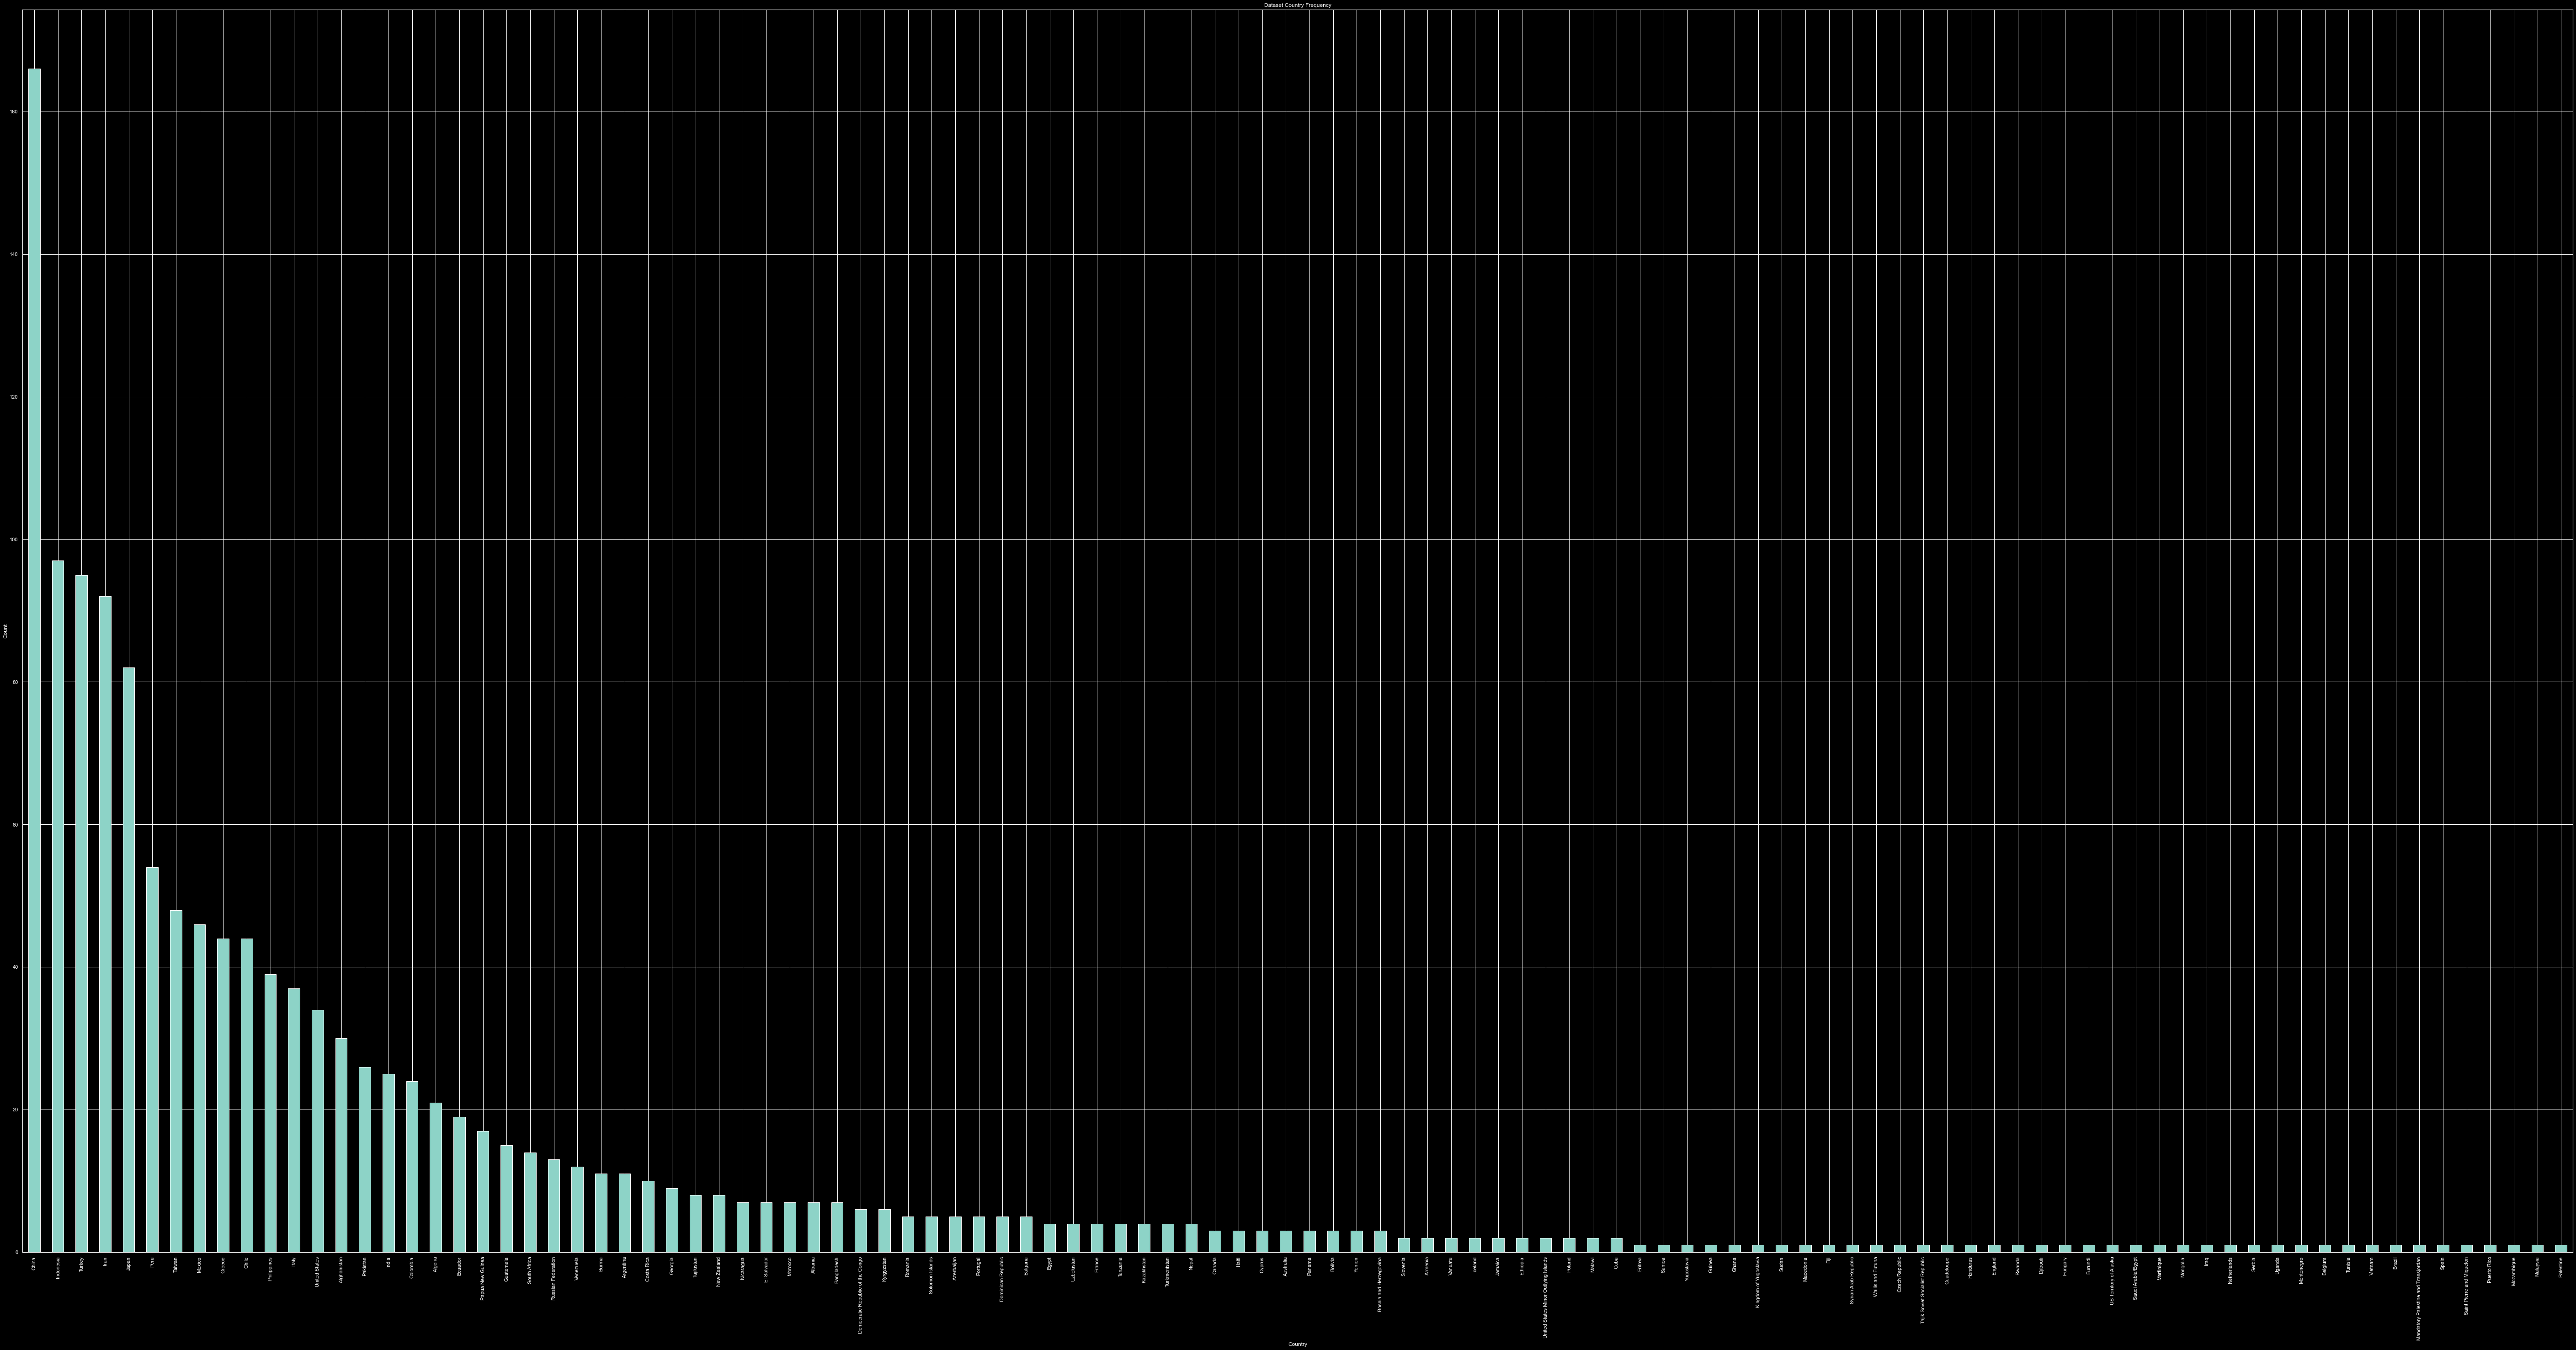

In [50]:
world_earthquakes["country"].value_counts().plot(kind="bar", figsize=(100,50))
plt.title("Dataset Country Frequency")
plt.xlabel("Country")
plt.ylabel("Count");

**Sidenotes/Remarks:**
- It looks the distribution is quite skewed: Some countries have more earthquakes than the others.

#### Who are the top 25 countries?

Let's look at the top 25 countries.

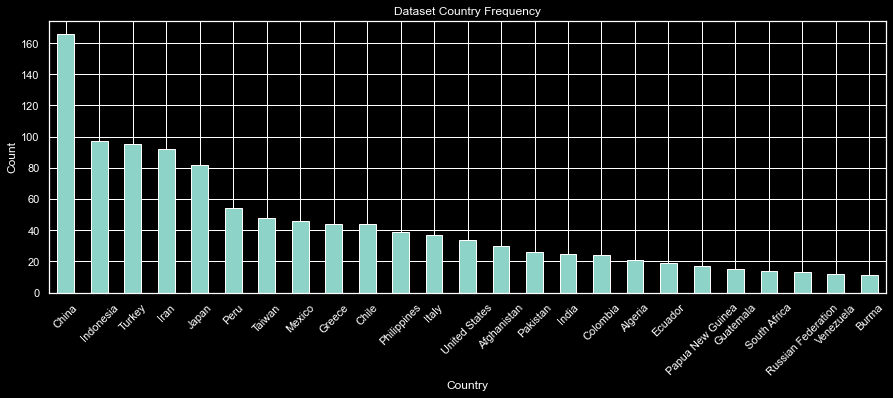

In [51]:
world_earthquakes["country"].value_counts()[:25].plot(kind="bar", rot=45, figsize=(15,5))
plt.title("Dataset Country Frequency")
plt.xlabel("Country")
plt.ylabel("Count");

In [42]:
world_earthquakes["country"].value_counts()[:25]

China                 166
Indonesia              97
Turkey                 95
Iran                   92
Japan                  82
Peru                   54
Taiwan                 48
Mexico                 46
Greece                 44
Chile                  44
Philippines            39
Italy                  37
United States          34
Afghanistan            30
Pakistan               26
India                  25
Colombia               24
Algeria                21
Ecuador                19
Papua New Guinea       17
Guatemala              15
South Africa           14
Russian Federation     13
Venezuela              12
Burma                  11
Name: country, dtype: int64

**Sidenotes/Remarks:**
- China is the top country where the most earthquakes are reported from.
- The top 5 countries are all on the Asia continent.
  - *Maybe we should look more into the distribution on the continent level?*
- Japan is ranked 5th.
- USA is ranked 13th.

#### Who are the bottom 25 countries?

Let's look at the bottom 25 countries.

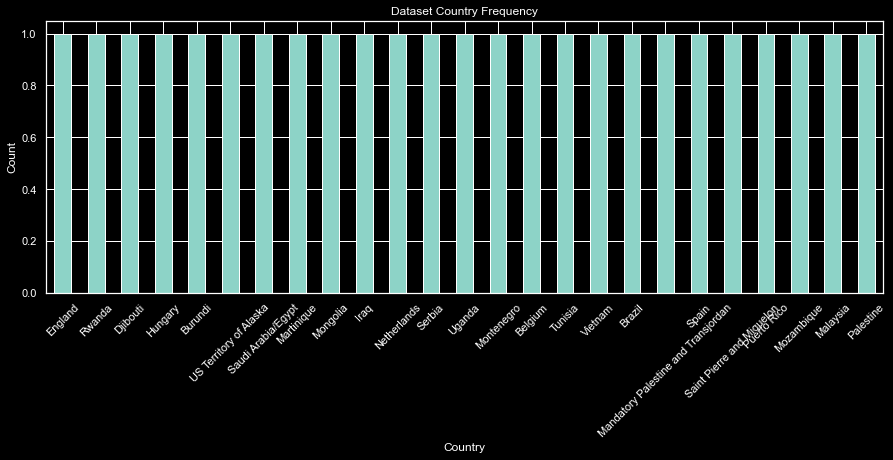

In [52]:
world_earthquakes["country"].value_counts()[-25:].plot(kind="bar", rot=45, figsize=(15,5))
plt.title("Dataset Country Frequency")
plt.xlabel("Country")
plt.ylabel("Count");

**Sidenotes/Remarks:**
- These countries only reported a single incident from this dataset.
- This could be used to confirm how infrequent earthquakes are in these countries
- We could be more specific and check all countries who only reported a single incident from this dataset
- **So the range of the country frequency is from 1 to 166 (China)**

#### How many countries only reported a single incident in this dataset?

In [44]:
single_freq_countries = world_earthquakes["country"].value_counts()[world_earthquakes["country"].value_counts().to_frame()["country"] == 1]
single_freq_countries.count()

40

#### Who are these countries?

In [45]:
single_freq_countries.sort_index()

Belgium                                1
Brazil                                 1
Burundi                                1
Czech Republic                         1
Djibouti                               1
England                                1
Eritrea                                1
Fiji                                   1
Ghana                                  1
Guadeloupe                             1
Guinea                                 1
Honduras                               1
Hungary                                1
Iraq                                   1
Kingdom of Yugoslavia                  1
Macedonia                              1
Malaysia                               1
Mandatory Palestine and Transjordan    1
Martinique                             1
Mongolia                               1
Montenegro                             1
Mozambique                             1
Netherlands                            1
Palestine                              1
Puerto Rico     

#### Who are the middle countries?

These have noticed that the top 24 countries reported between 166 (China) and 12 (Venezuela). And the bottom 40 reported only a single instance of earthquake. Let's look at the middle that doe not meet those criteria and see their distribution.

In [46]:
mid_freq_countries = world_earthquakes["country"].value_counts()[
    (world_earthquakes["country"].value_counts().to_frame()["country"] < 12) &
    (world_earthquakes["country"].value_counts().to_frame()["country"] > 1)
]
mid_freq_countries.count()

44

In [47]:
mid_freq_countries

Burma                                   11
Argentina                               11
Costa Rica                              10
Georgia                                  9
Tajikistan                               8
New Zealand                              8
Nicaragua                                7
El Salvador                              7
Morocco                                  7
Albania                                  7
Bangladesh                               7
Democratic Republic of the Congo         6
Kyrgyzstan                               6
Romania                                  5
Solomon Islands                          5
Azerbaijan                               5
Portugal                                 5
Dominican Republic                       5
Bulgaria                                 5
Egypt                                    4
Uzbekistan                               4
France                                   4
Tanzania                                 4
Kazakhstan 

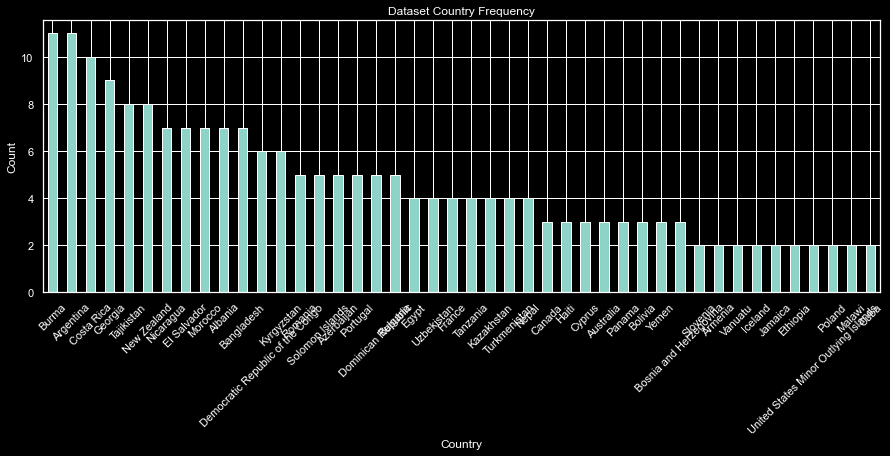

In [53]:
mid_freq_countries.plot(kind="bar", rot=45, figsize=(15,5))
plt.title("Dataset Country Frequency")
plt.xlabel("Country")
plt.ylabel("Count");

#### Which locations do not have lat/long/depth/magnitude data?

We notice that there are more countries than there is `(lat,long)` data. Let's see which countries do not have `(lat,long)`

In [56]:
world_earthquakes[(world_earthquakes["latitude"].isna()) | (world_earthquakes["longitude"].isna())]

,date,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
439,1966-04-25 23:22:00,Uzbekistan,NaN,NaN,NaN,5.0,NaN,10
1318,2008-10-06 16:30:00,China,NaN,NaN,NaN,6.4,NaN,0
1319,2008-10-28 23:09:00,Pakistan,NaN,NaN,NaN,6.4,NaN,215
1322,2009-07-09 11:19:00,China,NaN,NaN,NaN,5.7,NaN,0
1323,2009-08-10 20:07:00,Japan,NaN,NaN,NaN,6.4,NaN,1
1324,2009-09-02 07:55:00,Indonesia,NaN,NaN,NaN,7.0,NaN,79
1325,2009-09-29 17:48:00,Samoa,NaN,NaN,8.1,8.1,NaN,189
1326,2009-09-30 10:16:00,Indonesia,NaN,NaN,NaN,7.6,NaN,1115
1329,2010-03-08 02:32:00,Turkey,NaN,NaN,NaN,6.1,NaN,42
1330,2010-03-11 14:39:00,Chile,NaN,NaN,NaN,6.9,landslide,1


### Strength of the earthquake

#### Which records do not have `depth` reported?

In [58]:
world_earthquakes[world_earthquakes["depth"].isna()]

,date,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
1,1900-07-12 06:25:00,Turkey,40.30,43.10,NaN,5.9,NaN,140
4,1901-03-31 07:11:00,Bulgaria,43.40,28.70,NaN,6.4,NaN,4
9,1902-03-09 07:46:00,Turkey,40.70,33.60,NaN,5.5,NaN,4
15,1903-03-29 22:30:00,Palestine,32.20,35.30,NaN,5.7,NaN,20
16,1903-04-28 00:00:00,Turkey,39.14,42.65,NaN,7.0,NaN,3500
...,...,...,...,...,...,...,...,...
1330,2010-03-11 14:39:00,Chile,NaN,NaN,NaN,6.9,landslide,1
1331,2010-04-14 23:49:00,China,NaN,NaN,NaN,6.9,landslide,2698
1332,2011-02-21 23:51:00,New Zealand,NaN,NaN,NaN,6.3,liquification,185
1333,2011-03-10 04:58:00,China,NaN,NaN,NaN,5.4,NaN,0


#### Which records do not have `magnitude` reported?

In [59]:
world_earthquakes[world_earthquakes["magnitude"].isna()]

,date,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
104,1921-08-14,Eritrea,15.61,39.445,NaN,NaN,NaN,0


#### Which records do not have `secondary_effects reported`?

In [60]:
world_earthquakes[world_earthquakes["secondary_effects"].isna()]

,date,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
0,1900-05-11 17:23:00,Japan,38.7,141.1,5.0,7.0,NaN,0
1,1900-07-12 06:25:00,Turkey,40.3,43.1,NaN,5.9,NaN,140
2,1900-10-29 09:11:00,Venezuela,11.0,-66.0,0.0,7.7,NaN,0
3,1901-02-15 00:00:00,China,26.0,100.1,0.0,6.5,NaN,0
4,1901-03-31 07:11:00,Bulgaria,43.4,28.7,NaN,6.4,NaN,4
...,...,...,...,...,...,...,...,...
1333,2011-03-10 04:58:00,China,NaN,NaN,NaN,5.4,NaN,0
1335,2011-03-24 20:25:00,Burma,NaN,NaN,NaN,6.8,NaN,150
1336,2011-04-07 14:32:00,Japan,38.2,140.0,66.0,7.1,NaN,0
1338,2011-09-23 10:41:00,Turkey,38.6,43.5,7.2,7.1,NaN,601


#### Which records do not have `deaths` reported?

In [63]:
world_earthquakes[world_earthquakes["deaths"] == 0]

,date,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
0,1900-05-11 17:23:00,Japan,38.7,141.1,5.0,7.0,NaN,0
2,1900-10-29 09:11:00,Venezuela,11.0,-66.0,0.0,7.7,NaN,0
3,1901-02-15 00:00:00,China,26.0,100.1,0.0,6.5,NaN,0
5,1901-08-09 09:23:00,Japan,40.5,142.5,35.0,7.2,tsunami,0
11,1902-07-03 15:36:00,China,43.2,129.6,20.0,6.7,NaN,0
...,...,...,...,...,...,...,...,...
1318,2008-10-06 16:30:00,China,NaN,NaN,NaN,6.4,NaN,0
1322,2009-07-09 11:19:00,China,NaN,NaN,NaN,5.7,NaN,0
1333,2011-03-10 04:58:00,China,NaN,NaN,NaN,5.4,NaN,0
1336,2011-04-07 14:32:00,Japan,38.2,140.0,66.0,7.1,NaN,0


#### Which records have `deaths` reported?

In [64]:
world_earthquakes[world_earthquakes["deaths"] > 0]

,date,country,latitude,longitude,depth,magnitude,secondary_effects,deaths
1,1900-07-12 06:25:00,Turkey,40.300,43.100,NaN,5.9,NaN,140
4,1901-03-31 07:11:00,Bulgaria,43.400,28.700,NaN,6.4,NaN,4
6,1901-11-15 20:15:00,New Zealand,-43.000,173.000,0.0,6.8,NaN,1
7,1902-01-30 14:01:00,Japan,40.500,141.300,35.0,6.9,NaN,1
8,1902-02-13 09:39:00,Azerbaijan,40.700,48.600,15.0,6.9,NaN,86
...,...,...,...,...,...,...,...,...
1332,2011-02-21 23:51:00,New Zealand,NaN,NaN,NaN,6.3,liquification,185
1334,2011-03-11 14:46:00,Japan,38.322,142.369,24.4,9.0,tsunami,15894
1335,2011-03-24 20:25:00,Burma,NaN,NaN,NaN,6.8,NaN,150
1337,2011-09-18 12:40:00,India,27.723,88.064,19.7,6.9,landslide,111


#### What is the distribution of `depth`?

We will only consider the ones that are not `na`. Depth is reported in Km.

In [76]:
depth_data.describe()

count    1250.000000
mean       29.531840
std        44.886951
min         0.000000
25%        10.000000
50%        18.000000
75%        35.000000
max       644.600000
Name: depth, dtype: float64

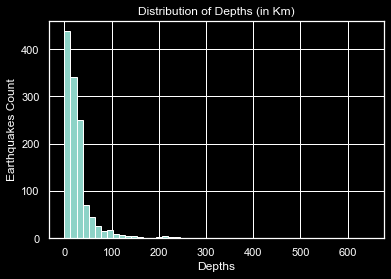

In [111]:
depth_data = world_earthquakes[~world_earthquakes["depth"].isna()]['depth']
# sns.distplot(depth_data)
plt.hist(depth_data, bins=50)
plt.title("Distribution of Depths (in Km)")
plt.xlabel("Depths")
plt.ylabel("Earthquakes Count");

#### What is the distribution of `magnitude`?

We will only consider the ones that are not `na`

In [75]:
magnitude_data.describe()

count    1339.000000
mean        6.398146
std         0.967859
min         2.000000
25%         5.700000
50%         6.400000
75%         7.100000
max         9.500000
Name: magnitude, dtype: float64

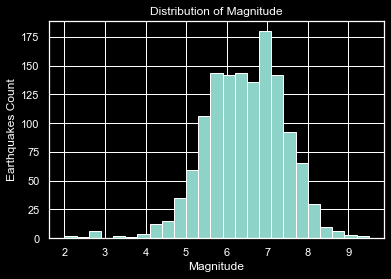

In [110]:
magnitude_data = world_earthquakes[~world_earthquakes["magnitude"].isna()]['magnitude']
# sns.distplot(magnitude_data)
plt.hist(magnitude_data, bins=25)
plt.title("Distribution of Magnitude")
plt.xlabel("Magnitude")
plt.ylabel("Earthquakes Count");

#### What is the distribution of `deaths`?

We will only consider the ones that are not `na`.

In [74]:
deaths_data.describe()

count      1340.000000
mean       2188.773134
std       22612.847499
min           0.000000
25%           2.000000
50%           8.000000
75%          76.500000
max      655237.000000
Name: deaths, dtype: float64

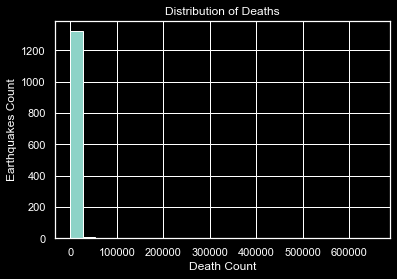

In [112]:
deaths_data = world_earthquakes[~world_earthquakes["deaths"].isna()]['deaths']
plt.hist(deaths_data, bins=25)
plt.title("Distribution of Deaths")
plt.xlabel("Death Count")
plt.ylabel("Earthquakes Count");

It appears that most of the earthquakes did not cause deaths. What if we only focus on the ones which did?

In [115]:
deaths_data

0         0
1       140
2         0
3         0
4         4
       ... 
1335    150
1336      0
1337    111
1338    601
1339      0
Name: deaths, Length: 1340, dtype: int64

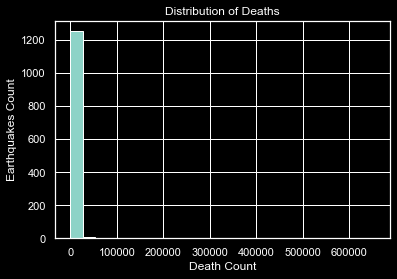

In [119]:
deaths_only_data = deaths_data[deaths_data > 0]
plt.hist(deaths_only_data, bins=25)
plt.title("Distribution of Deaths")
plt.xlabel("Death Count")
plt.ylabel("Earthquakes Count");

In [118]:
deaths_only_data

1         140
4           4
6           1
7           1
8          86
        ...  
1332      185
1334    15894
1335      150
1337      111
1338      601
Name: deaths, Length: 1270, dtype: int64

This data set is still highly skewed. Let's apply a log transformation to visualize better.

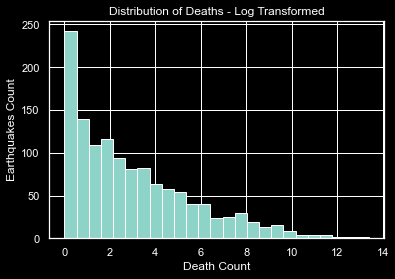

In [120]:
deaths_only_data_log = np.log(deaths_only_data)
plt.hist(deaths_only_data_log, bins=25)
plt.title("Distribution of Deaths - Log Transformed")
plt.xlabel("Death Count")
plt.ylabel("Earthquakes Count");